In [1]:
%cd ./dataset

/home/server1/workdir/project_ing/SK_temp/AiStages/RecycleDetection/dataset


In [10]:
import json
import cv2
import glob
import os
import pandas as pd
import pprint

/home/server1/workdir/project_ing/SK_temp/AiStages/RecycleDetection/venv/workdir/all_venv/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
with open('train.json', 'r') as f:
    train_json = json.load(f)

with open('test.json', 'r') as f:
    test_json = json.load(f)

In [7]:
pprint.pprint(train_json.keys())

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])


In [8]:
pprint.pprint(test_json.keys())

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])


In [12]:
images_df = pd.json_normalize(train_json['images'])
ann_df = pd.json_normalize(train_json['annotations'])

In [13]:
# images details
images_df.head()

width  height       file_name  license flickr_url coco_url  \
0   1024    1024  train/0000.jpg        0       None     None   
1   1024    1024  train/0001.jpg        0       None     None   
2   1024    1024  train/0002.jpg        0       None     None   
3   1024    1024  train/0003.jpg        0       None     None   
4   1024    1024  train/0004.jpg        0       None     None   

         date_captured  id  
0  2020-12-26 14:44:23   0  
1  2021-01-10 16:30:39   1  
2  2020-12-27 17:55:52   2  
3  2021-03-31 12:10:36   3  
4  2021-01-01 18:52:38   4

In [14]:
# annotation details
ann_df.head()

image_id  category_id       area                          bbox  iscrowd  id
0         0            0  257301.66  [197.6, 193.7, 547.8, 469.7]        0   0
1         1            3   10402.56     [0.0, 407.4, 57.6, 180.6]        0   1
2         1            7   26259.36    [0.0, 455.6, 144.6, 181.6]        0   2
3         1            4   69096.17  [722.3, 313.4, 274.3, 251.9]        0   3
4         1            5   24164.58  [353.2, 671.0, 233.7, 103.4]        0   4

In [15]:
# total train length
len(images_df)

4883

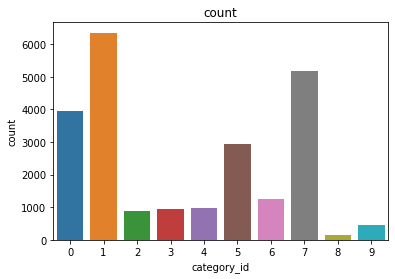

{0: 'General trash',
 1: 'Paper',
 2: 'Paper pack',
 3: 'Metal',
 4: 'Glass',
 5: 'Plastic',
 6: 'Styrofoam',
 7: 'Plastic bag',
 8: 'Battery',
 9: 'Clothing'}


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='category_id', data=ann_df)
plt.title('count')
plt.show()

category_dict = {i['id']:i['name'] for i in train_json['categories']}
pprint.pprint(category_dict)

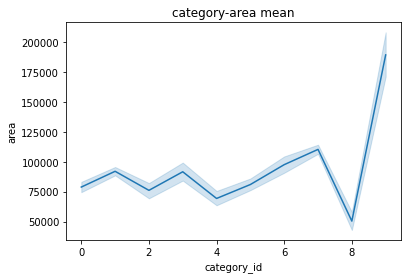

In [20]:
sns.lineplot(data=ann_df, x='category_id', y='area')
plt.title('category-area mean')
plt.show()

In [21]:
# check bbox number per image
bbox_per_image = ann_df['image_id'].value_counts()
print(bbox_per_image.head())
print(bbox_per_image.tail())

4197    71
946     55
4047    52
394     48
2981    46
Name: image_id, dtype: int64
3359    1
3357    1
1605    1
1608    1
0       1
Name: image_id, dtype: int64


In [25]:
area_sort_df = ann_df.sort_values(by=['area'])
print(area_sort_df.head())
print(area_sort_df.tail())

       image_id  category_id    area                       bbox  iscrowd  \
5159       1063            0    0.56   [647.8, 460.2, 0.7, 0.8]        0   
6539       1377            1    3.12   [719.8, 604.7, 1.3, 2.4]        0   
17594      3712            2   66.25  [883.8, 638.5, 12.5, 5.3]        0   
5067       1056            5  105.08   [530.6, 70.9, 14.2, 7.4]        0   
7227       1521            3  275.12  [728.4, 307.8, 36.2, 7.6]        0   

          id  
5159    5159  
6539    6539  
17594  17594  
5067    5067  
7227    7227  
       image_id  category_id        area                        bbox  iscrowd  \
10443      2194            0  1048064.06  [0.0, 0.0, 1023.8, 1023.7]        0   
15633      3289            1  1048064.06  [0.0, 0.0, 1023.8, 1023.7]        0   
6537       1377            0  1048064.06  [0.0, 0.0, 1023.8, 1023.7]        0   
11449      2422            0  1048064.06  [0.0, 0.0, 1023.7, 1023.8]        0   
5565       1160            7  1048371.21  [0.0, 

In [53]:
# make color dictionary for bbox
import numpy as np

color_dict = {i: tuple(map(int,np.random.choice(range(256), size=3))) for i in range(len(train_json['categories']))}
print(color_dict)

{0: (196, 75, 149), 1: (204, 116, 9), 2: (181, 83, 75), 3: (201, 239, 163), 4: (177, 134, 207), 5: (60, 242, 228), 6: (58, 160, 215), 7: (206, 61, 70), 8: (193, 200, 86), 9: (126, 149, 198)}


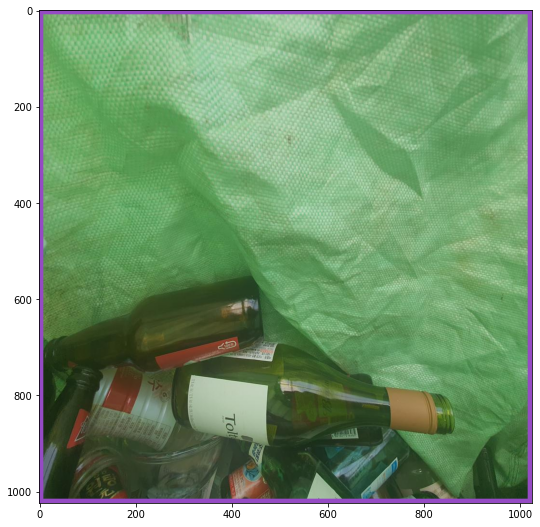

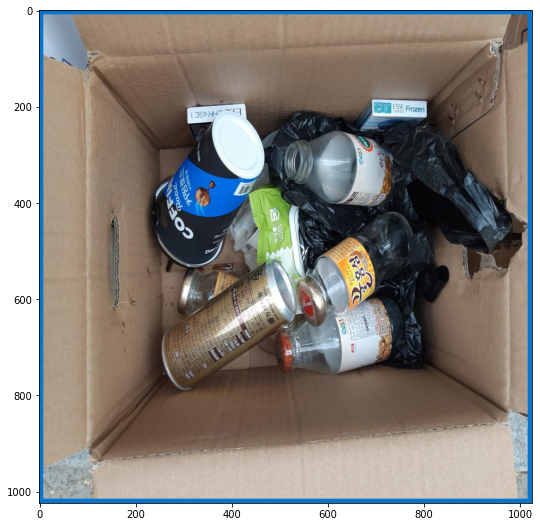

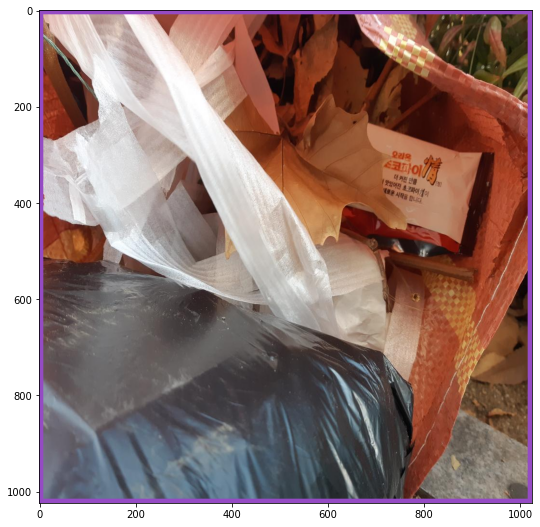

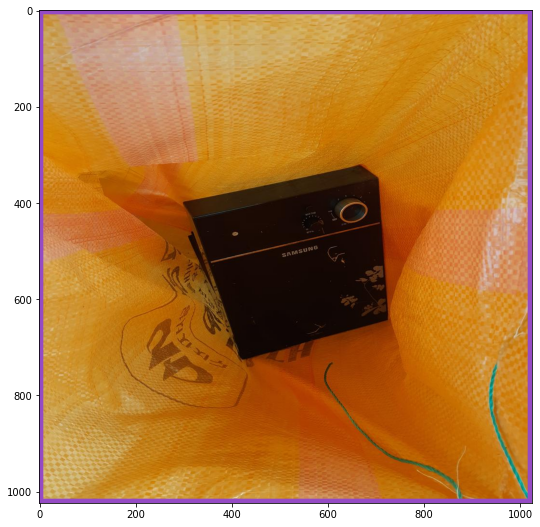

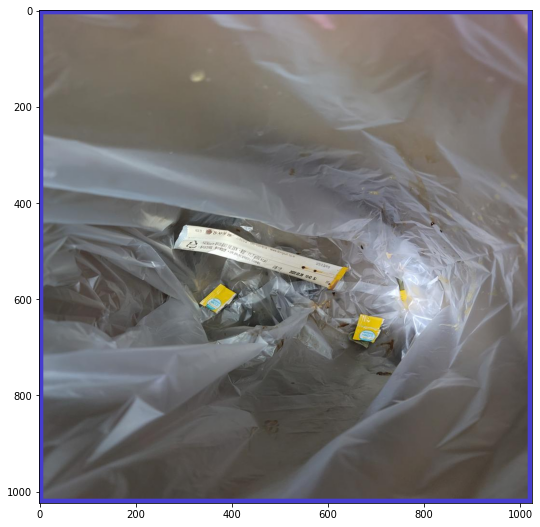

In [63]:
# show small bbox image
files = area_sort_df.tail()

for i, (_,file_list) in enumerate(files.iterrows()):
    img = cv2.imread(train_json['images'][file_list['image_id']]['file_name'])
    cls = train_json['categories'][file_list['category_id']]['name']
    bbox = file_list['bbox']
    top_left = (int(bbox[0]), int(bbox[1]))
    bottom_right = (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3]))
    color = color_dict[file_list['category_id']]
    img = cv2.rectangle(img, top_left, bottom_right, color, 15)
    cv2.putText(img, cls, (int(bbox[0]), int(bbox[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(30,30))
    plt.subplot(2,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()


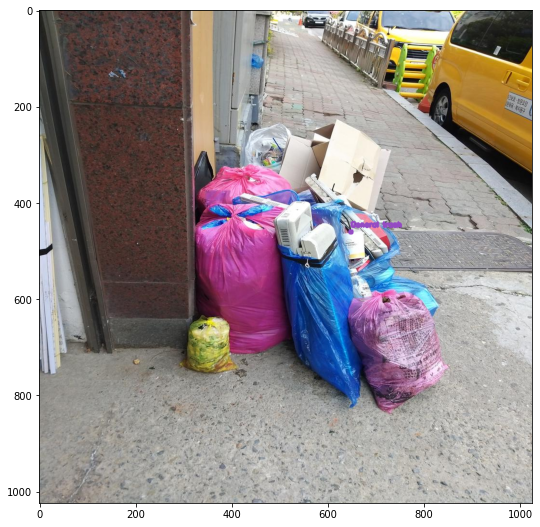

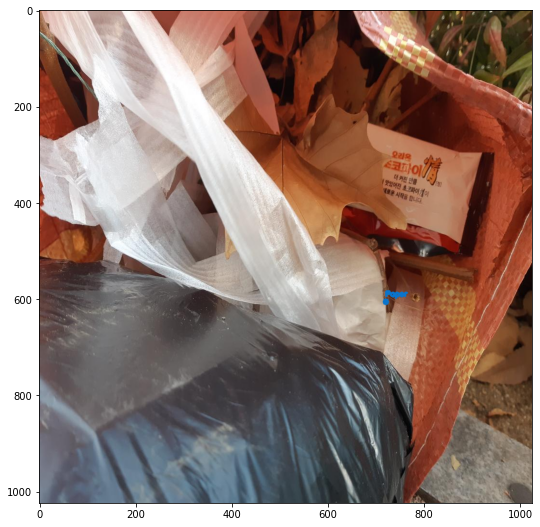

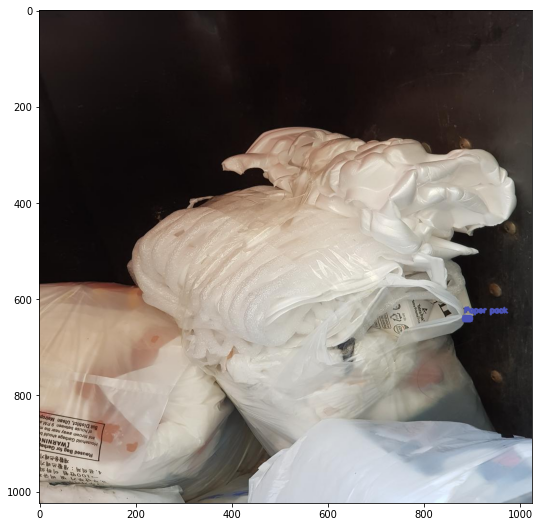

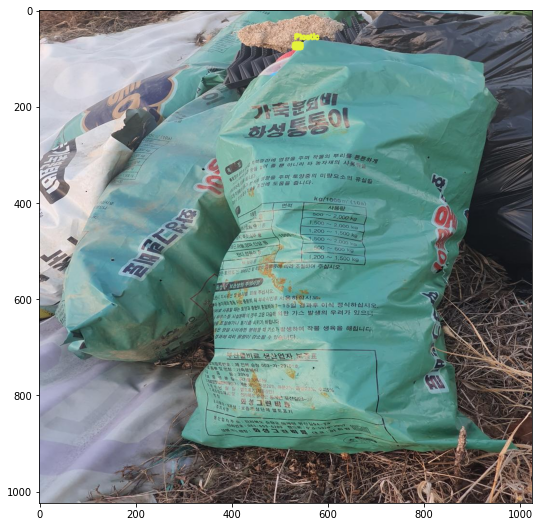

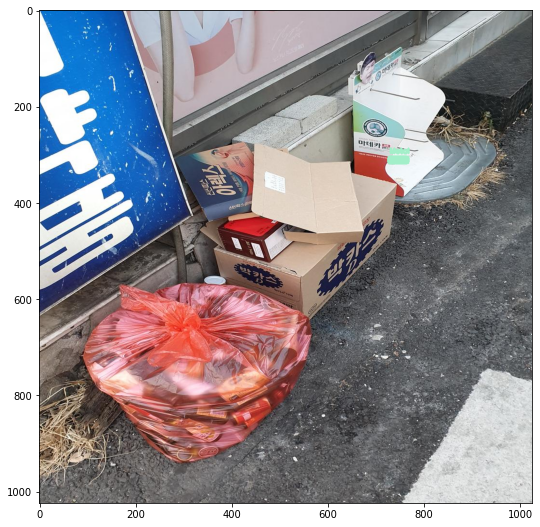

In [65]:
# show small bbox image
files = area_sort_df.head()

for i, (_,file_list) in enumerate(files.iterrows()):
    img = cv2.imread(train_json['images'][file_list['image_id']]['file_name'])
    cls = train_json['categories'][file_list['category_id']]['name']
    bbox = file_list['bbox']
    top_left = (int(bbox[0]), int(bbox[1]))
    bottom_right = (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3]))
    color = color_dict[file_list['category_id']]
    img = cv2.rectangle(img, top_left, bottom_right, color, 10)
    cv2.putText(img, cls, (int(bbox[0]), int(bbox[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 3)

    plt.figure(figsize=(30,30))
    plt.subplot(2,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

In [66]:
# get train dataset image std
from collections import defaultdict

imgs_info = defaultdict(list)
for path in glob.glob('./train/*'):
    img = np.array(cv2.imread(path))
    h, w, _ = img.shape
    imgs_info['mean'].append(img.mean(axis=(0,1)))
    imgs_info['std'].append(img.std(axis=(0,1)))

print(f'Image RGB mean is {np.mean(imgs_info["mean"], axis=0)}')
print(f'Image RGB std is {np.mean(imgs_info["std"], axis=0)}')

Image RGB mean is [110.07439221 117.39781397 123.65060953]
Image RGB std is [54.77174141 53.35981744 54.01141646]
